# Sound Classification using CNN

This notebook is based on UrbanSound 8k dataset

## Import libs

In [1]:
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler

In [2]:
import os
import librosa
import librosa.display

In [21]:
import torch
from torch.utils.data import Dataset, DataLoader

## Reading data

In [3]:
df = pd.read_csv("./data/UrbanSound8K.csv")
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


## Spectograms

I'm using librosa to create spectrograms from audiofiles

In [4]:
dat1, sampling_rate1 = librosa.load('./data/fold5/100032-3-0-0.wav')
dat2, sampling_rate2 = librosa.load('./data/fold5/100263-2-0-117.wav')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

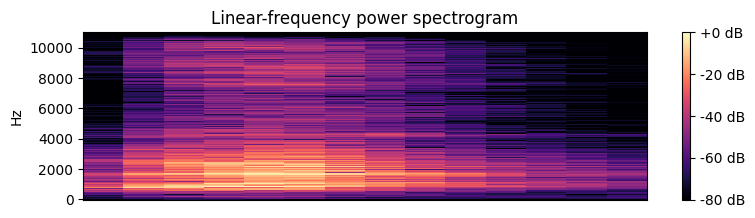

In [5]:
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat1)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

In [6]:
D.shape

(1025, 14)

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

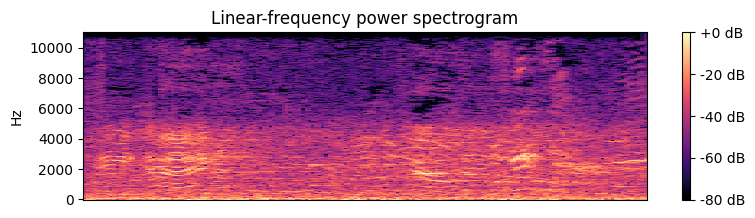

In [7]:
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

In [8]:
D.shape

(1025, 173)

(1025, 173)
(1025, 173)
(1025, 173)


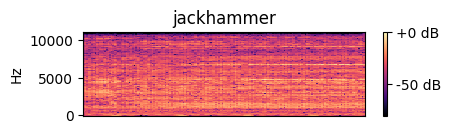

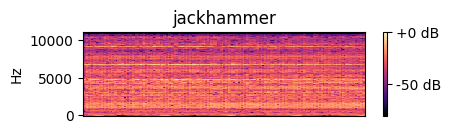

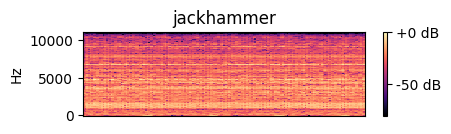

In [9]:
'''Using random samples to observe difference in waveforms.'''

arr = np.array(df["slice_file_name"])
fold = np.array(df["fold"])
cla = np.array(df["class"])

for i in range(400, 405, 2):
    path = './data/fold' + str(fold[i]) + '/' + arr[i]
    data, sampling_rate = librosa.load(path)
    plt.figure(figsize=(10, 5))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    print(D.shape)
    plt.subplot(4, 2, 1)
    librosa.display.specshow(D, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(cla[i])

### Melspectrogram

(128, 173)

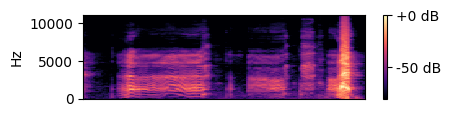

In [10]:
dat1, sampling_rate1 = librosa.load('./data/fold5/34872-3-0-2.wav')
arr = librosa.feature.melspectrogram(y=dat1, sr=sampling_rate1, hop_length = 512, n_fft = 2048)
plt.figure(figsize=(10, 5))
plt.subplot(4, 2, 1)
librosa.display.specshow(librosa.power_to_db(arr, ref=np.max), y_axis='linear')
plt.colorbar(format='%+2.0f dB')
arr.shape

### Parsing data

In [11]:
feature = []
label = []

def parser(row):
    # Function to load files and extract features
    for i in range(8732):
        file_name = './data/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
        X, sample_rate = librosa.load(file_name) 
        # We extract mfcc feature from data
        mels = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)        
        feature.append(mels)
        label.append(df["classID"][i])
    return [feature, label]

In [12]:
temp = parser(df)

/home/aidar/.local/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/home/aidar/.local/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/home/aidar/.local/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [13]:
temp = np.array(temp, dtype='object')
data = temp.transpose()

In [14]:
X_ = data[:, 0]
Y = data[:, 1]
print(X_.shape, Y.shape)
X = np.empty([8732, 128])

(8732,) (8732,)


In [15]:
for i in range(8732):
    X[i] = (X_[i])

In [16]:
X.shape

(8732, 128)

In [19]:
X = X.reshape(8732, 1, 16, 8)
X.shape

(8732, 1, 16, 8)

## Creating final Dataset

In [22]:
class UrbanSoundDataset(Dataset):
    def __init__(self, Y, X, transform = None):
        self.annotation = Y
        self.data = X
        self.transform = transform
    def __len__(self):
        return len(self.annotation)
    def __getitem__(self, idx):
        label = Y[idx]
        data = X[idx]
        sample = (data, label)

        if self.transform:
            sample = self.transform(sample)

        return sample

In [23]:
dataset = UrbanSoundDataset(Y, X)

In [24]:
train_set, test_set = torch.utils.data.random_split(dataset, [7732, 1000])

In [25]:
train_loader = DataLoader(dataset=train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=len(test_set), shuffle=True)

In [26]:
train = iter(train_loader)
sound, label = next(train)

In [27]:
sound = sound.float()

In [28]:
sound = sound[0].reshape(16, 8)

Text(0.5, 1.0, '4')

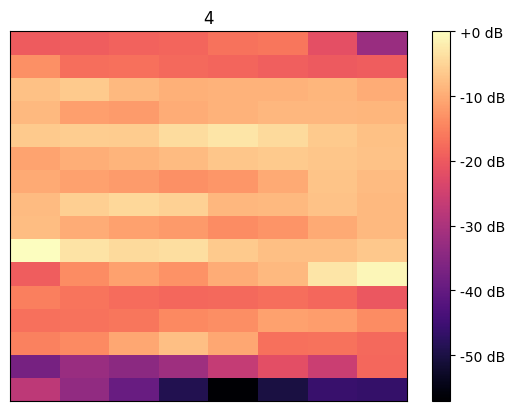

In [29]:
librosa.display.specshow(librosa.power_to_db(sound, ref=np.max))
plt.colorbar(format='%+2.0f dB')
plt.title(label[0].item())

## Creating CNN model

Creating CNN with 2 conv. layers and 2 linear layer

In [30]:
import torch.nn as nn
import torch.nn.functional as F

In [31]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels=64, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same')
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 10)
    def forward(self, x):
        x = F.tanh(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.tanh(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.dropout(x, p=0.1, training=self.training)
        x = x.view(-1, 1024)
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return F.softmax(x, dim=1)

In [32]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


## Model training

In [33]:
loss_fn = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(cnn.parameters(), lr = lr)

In [34]:
from tqdm.notebook import tqdm

In [35]:
from sklearn.metrics import accuracy_score

In [36]:
loss_list = []
accuracy_list = []
epochs = 90
for epoch in tqdm(range(epochs)):
    running_loss = 0
    train_dataiter = iter(train_loader)
    current_loss = 0
    for i, batch in enumerate(tqdm(train_dataiter)):
        X_batch, y_batch = batch
        X_batch = X_batch.float()
        optimizer.zero_grad()
        y_pred = cnn(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        current_loss += loss
    loss_list.append(current_loss.item())
    test_dataiter = iter(test_loader)
    sound, labels = next(test_dataiter)
    sound = sound.float()
    accuracy_list.append(accuracy_score(labels.numpy(), np.argmax(cnn.forward(sound).detach().numpy(), axis = 1)))

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

## Model testing

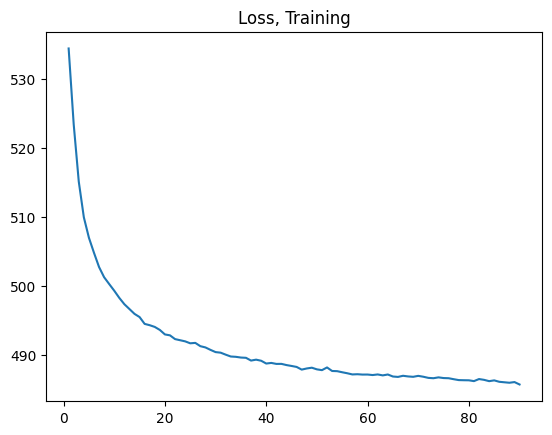

In [37]:
plt.plot(range(1, epochs+1), loss_list)
plt.title('Loss, Training')
plt.show()

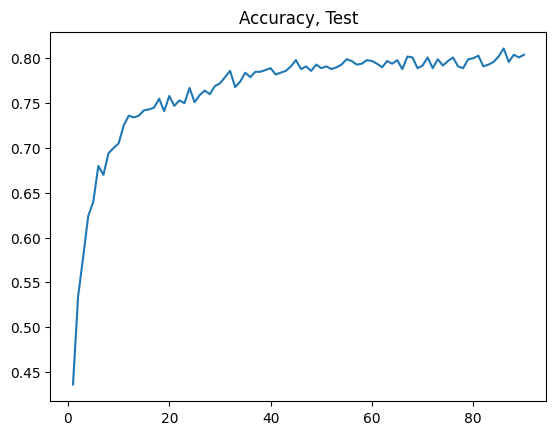

In [39]:
plt.plot(range(1, epochs+1), accuracy_list)
plt.title('Accuracy, Test')
plt.show()

In [40]:
test_dataiter = iter(test_loader)
sounds, labels = next(test_dataiter)
sounds = sounds.float()

In [41]:
from sklearn.metrics import accuracy_score

In [42]:
accuracy_score(labels.numpy(), np.argmax(cnn.forward(sounds).detach().numpy(), axis = 1))

0.805

In [48]:
import IPython.display as ipd

In [43]:
num_names = {
    0: 'air conditioner',
    1: 'car horn',
    2: 'children playing',
    3: 'dog bark',
    4: 'drilling',
    5: 'engine idling',
    6: 'gun shot',
    7: 'jackhammer',
    8: 'siren',
    9: 'street music'
}

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [45]:
confusion = confusion_matrix(labels.numpy(), np.argmax(cnn.forward(sounds).detach().numpy(), axis = 1))
display = ConfusionMatrixDisplay(confusion)

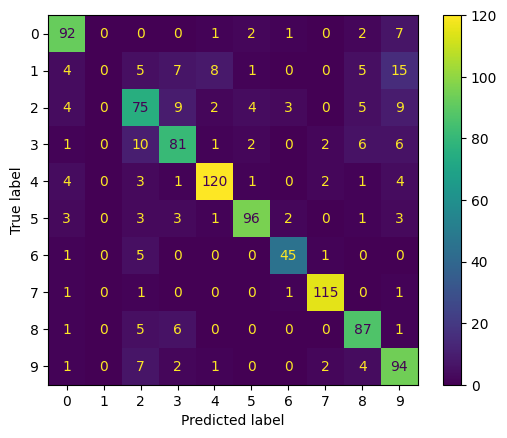

In [46]:
display.plot();

In [49]:
file_name = './test/50901-0-1-1.wav'
dat1, sampling_rate1 = librosa.load(file_name)
d = np.mean(librosa.feature.melspectrogram(y=dat1, sr=sampling_rate1).T,axis=0)
d = d.reshape(1, 16, 8)
d = torch.as_tensor(d)
print(num_names[torch.argmax(cnn.forward(d)).item()])
ipd.Audio(file_name)

air conditioner


In [51]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
